In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from itertools import combinations


In [7]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from itertools import combinations

IMG_WIDTH = 1248
IMG_HEIGHT = 828

def find_image_file(image_folder, partial_name):
    for fname in os.listdir(image_folder):
        if partial_name in fname:
            return fname
    return None

def load_image(image_path):
    img = Image.open(image_path).convert('L').resize((IMG_WIDTH, IMG_HEIGHT))
    img_arr = np.array(img).astype(np.float32) / 255.0
    return img_arr

def average_two_images(img1, img2):
    return (img1 + img2) / 2

def create_pair_data(csv_path, image_folder, output_csv_path, output_image_folder):
    df = pd.read_csv(csv_path)

    # Map partial_name -> (full filename, image array)
    partial_to_image = {}
    for partial_name in df.iloc[:, 0]:
        if partial_name not in partial_to_image:
            full_fname = find_image_file(image_folder, str(partial_name))
            if full_fname:
                img_arr = load_image(os.path.join(image_folder, full_fname))
                partial_to_image[partial_name] = (full_fname, img_arr)
            else:
                print(f"Warning: No image found for partial name '{partial_name}'")
                partial_to_image[partial_name] = (None, None)

    output_rows = []

    # Create output folder for averaged images
    os.makedirs(output_image_folder, exist_ok=True)

    for (idx1, row1), (idx2, row2) in combinations(df.iterrows(), 2):
        p1 = row1.iloc[0]
        p2 = row2.iloc[0]

        fname1, img1 = partial_to_image.get(p1, (None, None))
        fname2, img2 = partial_to_image.get(p2, (None, None))

        if img1 is None or img2 is None:
            print(f"Skipping pair ({p1}, {p2}) due to missing image.")
            continue

        avg_img = average_two_images(img1, img2)

        data1 = row1.iloc[1:]
        data2 = row2.iloc[1:]
        avg_data = (data1.values.astype(float) + data2.values.astype(float)) / 2

        row = {
            'partial_name_1': p1,
            'image_file_1': fname1,
            'partial_name_2': p2,
            'image_file_2': fname2,
        }

        for col, val in zip(df.columns[1:], avg_data):
            row[col] = val

        output_rows.append(row)

        # Save averaged image
        avg_img_uint8 = (avg_img * 255).astype(np.uint8)
        avg_img_filename = f"{p1}_{p2}_avg.png"
        Image.fromarray(avg_img_uint8).save(os.path.join(output_image_folder, avg_img_filename))

    output_df = pd.DataFrame(output_rows)
    output_df.to_csv(output_csv_path, index=False)
    print(f"Saved averaged pairs CSV to: {output_csv_path}")
    print(f"Saved averaged images to folder: {output_image_folder}")


In [8]:
data_csv_path = r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\Climate_data_cleaned_for_binary_image.csv"
image_folder_path = r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Binary Images"
output_csv_path = r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\bootstrapped_image.csv"
out_folder_path = r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\output_images"
create_pair_data(data_csv_path, image_folder_path, output_csv_path, out_folder_path)


Saved averaged pairs CSV to: C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\bootstrapped_image.csv
Saved averaged images to folder: C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\output_images


## Calculating Optimal WSA diffrence threshold


🔍 Total pairs evaluated: 33411

✅ Suggested threshold (25th percentile): 3.5460


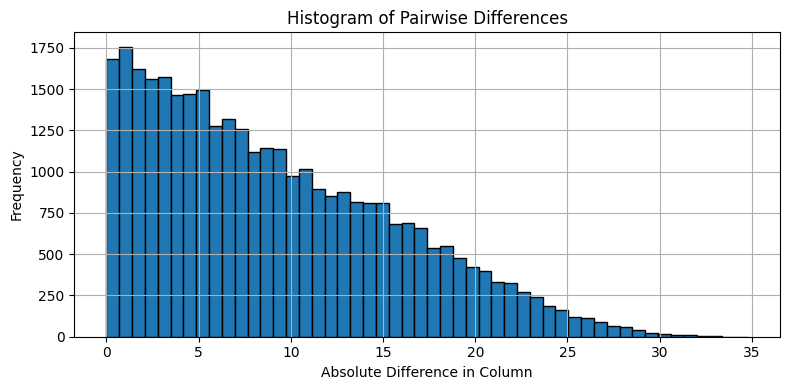

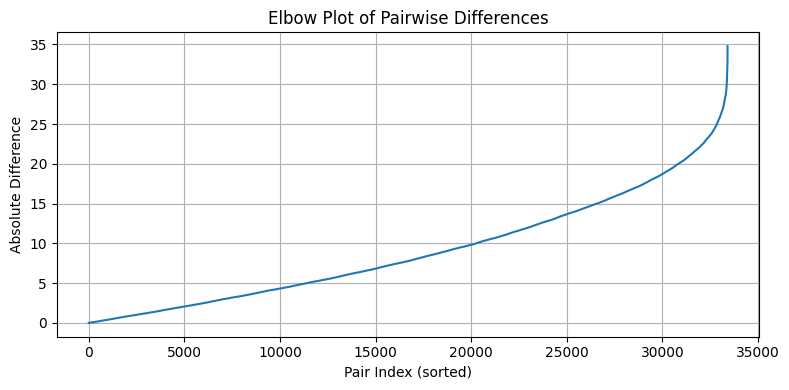

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def calculate_pairwise_differences(df, column_index=9):
    col_name = df.columns[column_index]
    values = df[col_name].astype(float).values

    diffs = [
        abs(values[i] - values[j])
        for i, j in combinations(range(len(values)), 2)
    ]
    return diffs

def plot_histogram(diffs, bins=50):
    plt.figure(figsize=(8, 4))
    plt.hist(diffs, bins=bins, edgecolor='black')
    plt.xlabel("Absolute Difference in Column")
    plt.ylabel("Frequency")
    plt.title("Histogram of Pairwise Differences")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_elbow(diffs):
    sorted_diffs = np.sort(diffs)
    plt.figure(figsize=(8, 4))
    plt.plot(sorted_diffs)
    plt.xlabel("Pair Index (sorted)")
    plt.ylabel("Absolute Difference")
    plt.title("Elbow Plot of Pairwise Differences")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def suggest_threshold(diffs, percentile=25):
    return np.percentile(diffs, percentile)

# === Run this part with your CSV ===
csv_path = r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\Climate Data.csv"  # ⬅️ Replace with your CSV path
df = pd.read_csv(csv_path)
diffs = calculate_pairwise_differences(df, column_index=9)

print(f"🔍 Total pairs evaluated: {len(diffs)}")

threshold = suggest_threshold(diffs, percentile=25)
print(f"\n✅ Suggested threshold (25th percentile): {threshold:.4f}")

plot_histogram(diffs)
plot_elbow(diffs)


## Weighted Averageing 


In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from itertools import combinations

# Constants
IMG_WIDTH = 1248
IMG_HEIGHT = 828
THRESHOLD = 3.54 # threshold for difference in 10th column

def find_image_file(image_folder, partial_name):
    for fname in os.listdir(image_folder):
        if partial_name in fname:
            return fname
    return None

def load_image(image_path):
    img = Image.open(image_path).convert('L').resize((IMG_WIDTH, IMG_HEIGHT))
    return np.array(img).astype(np.uint8)  # keep as binary (0 or 255)

def weighted_average_images(img1, img2):
    w1 = np.ones_like(img1, dtype=np.float32)
    w2 = np.ones_like(img2, dtype=np.float32)

    both_white = (img1 == 255) & (img2 == 255)
    both_black = (img1 == 0) & (img2 == 0)
    diff = img1 != img2

    w1[both_white] = 2
    w2[both_white] = 2

    w1[(img1 == 255) & diff] = 1
    w2[(img2 == 255) & diff] = 0.5

    w1[(img1 == 0) & diff] = 0.5
    w2[(img2 == 0) & diff] = 1

    weighted_avg = (img1 * w1 + img2 * w2) / (w1 + w2)

    # Apply threshold to return binary image
    return np.where(weighted_avg >= 127.5, 255, 0).astype(np.uint8)

def create_pair_data(csv_path, image_folder, output_csv_path, output_image_folder):
    df = pd.read_csv(csv_path)

    # Map partial_name -> (full filename, image array)
    partial_to_image = {}
    for partial_name in df.iloc[:, 0]:
        if partial_name not in partial_to_image:
            full_fname = find_image_file(image_folder, str(partial_name))
            if full_fname:
                img_arr = load_image(os.path.join(image_folder, full_fname))
                partial_to_image[partial_name] = (full_fname, img_arr)
            else:
                print(f"Warning: No image found for partial name '{partial_name}'")
                partial_to_image[partial_name] = (None, None)

    output_rows = []

    # Create output folder for averaged images
    os.makedirs(output_image_folder, exist_ok=True)

    for (idx1, row1), (idx2, row2) in combinations(df.iterrows(), 2):
        p1 = row1.iloc[0]
        p2 = row2.iloc[0]

        fname1, img1 = partial_to_image.get(p1, (None, None))
        fname2, img2 = partial_to_image.get(p2, (None, None))

        if img1 is None or img2 is None:
            print(f"Skipping pair ({p1}, {p2}) due to missing image.")
            continue

        # ✅ Threshold check on 10th column (index 9)
        column_to_check = df.columns[9]
        value1 = float(row1[column_to_check])
        value2 = float(row2[column_to_check])
        if abs(value1 - value2) > THRESHOLD:
            continue

        # Weighted average + thresholding
        avg_img = weighted_average_images(img1, img2)

        # Average the metadata values (excluding the name column)
        data1 = row1.iloc[1:].astype(float)
        data2 = row2.iloc[1:].astype(float)
        avg_data = (data1.values + data2.values) / 2

        # Build output row
        row = {
            'partial_name_1': p1,
            'image_file_1': fname1,
            'partial_name_2': p2,
            'image_file_2': fname2,
        }

        for col, val in zip(df.columns[1:], avg_data):
            row[col] = val

        output_rows.append(row)

        # Save averaged image
        avg_img_filename = f"{p1}_{p2}_avg.png"
        Image.fromarray(avg_img).save(os.path.join(output_image_folder, avg_img_filename))

    # Save new CSV
    output_df = pd.DataFrame(output_rows)
    output_df.to_csv(output_csv_path, index=False)

    print(f"\n✅ Saved averaged CSV: {output_csv_path}")
    print(f"🖼️ Saved averaged images to: {output_image_folder}")


In [5]:
create_pair_data(
    csv_path=r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\Climate Data.csv",
    image_folder=r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Binary Images(Original Dataset)",
    output_csv_path=r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\Pixel Wise Wieghted Averaging\weighted_avg_data.csv",
    output_image_folder=r"C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\Pixel Wise Wieghted Averaging\weighted_avg_images"
)


KeyboardInterrupt: 

## Converion to binary


In [ ]:
import cv2
import os

input_folder = r'C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\weighted_avg_images'
output_folder = r'C:\Users\sarwe\Desktop\Lake Shape Prediction\Bootstrapping_Binary_Image\binary_weighted_iavg'

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

        # Apply Otsu's thresholding
        _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, binary_img)

print("Conversion done using Otsu's method.")
